<a href="https://colab.research.google.com/github/harshithanayanigada/gans/blob/main/gans_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models


In [ ]:
GRADIENT_CLIP_THRESHOLD = 1.0
NOISE_DIM = 128  # Size of the noise vector
BATCH_SIZE = 128  # Batch size for training
EPOCHS = 150
NUM_CLASSES = 1000  # Number of classes in your dataset


In [ ]:
def apply_instance_noise(images, epoch=0, total_epochs=1, initial_noise_strength=0.1, decay_type='linear'):
    # Ensure epoch and total_epochs are tensors for TensorFlow compatibility
    epoch = tf.convert_to_tensor(epoch, dtype=tf.float32)
    total_epochs = tf.convert_to_tensor(total_epochs, dtype=tf.float32)
    # Calculate the current noise strength based on the epoch
    if decay_type == 'linear':
        noise_strength = initial_noise_strength * (1 - epoch / total_epochs)
    elif decay_type == 'exponential':
        noise_strength = initial_noise_strength * tf.math.exp(-epoch / total_epochs)
    else:
        raise ValueError("Unknown decay_type. Use 'linear' or 'exponential'.")
    # Generate and apply noise
    noise = noise_strength * tf.random.normal(shape=tf.shape(images))
    return images + noise


In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
# Discriminator loss function
def discriminator_loss(real_output, fake_output):
    # Label smoothing for real labels
    real_loss = cross_entropy(tf.ones_like(real_output) * 0.9, real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


In [ ]:
# Load ResNet50 model for perceptual loss
resnet = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(128, 128, 3))
resnet.trainable = False  # Freeze the ResNet weights
# Extract features from 'block3_conv3' layer
layer_name = 'conv3_block3_out'  # This is the name of the block3_conv3 layer in ResNet50
intermediate_model = tf.keras.Model(inputs=resnet.input, outputs=resnet.get_layer(layer_name).output)


In [ ]:
def perceptual_loss(y_true, y_pred):
    # Ensure both inputs have the same batch size
    batch_size = tf.shape(y_true)[0]
    y_pred = y_pred[:batch_size]
    # Preprocess images for ResNet50
    y_true_resnet = tf.keras.applications.resnet50.preprocess_input((y_true + 1) * 127.5)  # Convert from [-1,1] to [0,255]
    y_pred_resnet = tf.keras.applications.resnet50.preprocess_input((y_pred + 1) * 127.5)
    # Pass images to ResNet50 to get the intermediate layer activations
    y_true_features = intermediate_model(y_true_resnet)
    y_pred_features = intermediate_model(y_pred_resnet)
    # Calculate perceptual loss (using L1 norm between features)
    p_loss = tf.reduce_mean(tf.abs(y_true_features - y_pred_features))
    return p_loss


In [ ]:
def generator_loss_with_perceptual(fake_output, generated_images, real_images):
    gan_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    p_loss = perceptual_loss(real_images, generated_images)
    return gan_loss + 0.5 * p_loss  # Adjust the weight as needed


In [ ]:
class BigGANGenerator(tf.keras.Model):
    def __init__(self, noise_dim, num_classes):
        super(BigGANGenerator, self).__init__()
        self.noise_dim = noise_dim
        self.fc = layers.Dense(128 * 16 * 16, use_bias=False, input_shape=(noise_dim + num_classes,))
        self.bn = layers.BatchNormalization()
        self.conv_blocks = models.Sequential([
            layers.Reshape((16, 16, 128)),
            layers.BatchNormalization(),
            layers.UpSampling2D(),  # Upsample to 32x32
            layers.Conv2D(128, kernel_size=3, padding='same', use_bias=False),
            layers.ReLU(),
            layers.BatchNormalization(),
            layers.UpSampling2D(),  # Upsample to 64x64
            layers.Conv2D(64, kernel_size=3, padding='same', use_bias=False),
            layers.ReLU(),
            layers.BatchNormalization(),
            layers.UpSampling2D(),  # Upsample to 128x128
            layers.Conv2D(3, kernel_size=3, padding='same', use_bias=False),
            layers.Activation('tanh')  # Output range [-1, 1]
        ])
    def call(self, inputs, training=True):
        noise, class_vector = inputs
        x = tf.concat([noise, class_vector], axis=1)  # Concatenate noise and class vector
        x = self.fc(x)
        x = self.bn(x, training=training)
        return self.conv_blocks(x)


In [ ]:
pip install tensorflow==2.15.0  # Or any version between 2.13.0 and 2.15.x

In [ ]:
pip install --upgrade tensorflow-addons

In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers, models
# Spectral Normalization function
def spectral_norm(layer):
    return tfa.layers.SpectralNormalization(layer)

class BigGANDiscriminator(tf.keras.Model):
    def __init__(self, num_classes):
        super(BigGANDiscriminator, self).__init__()
        self.conv_blocks = models.Sequential([
            layers.Conv2D(64, kernel_size=3, strides=2, padding='same', input_shape=(128, 128, 3)),
            layers.ReLU(),
            layers.Conv2D(128, kernel_size=3, strides=2, padding='same'),
            layers.ReLU(),
            layers.Conv2D(256, kernel_size=3, strides=2, padding='same'),
            layers.ReLU(),
            layers.Conv2D(512, kernel_size=3, strides=2, padding='same'),
            layers.ReLU()
        ])
        # Apply Spectral Normalization to Conv2D layers
        for i, layer in enumerate(self.conv_blocks.layers):
            if isinstance(layer, layers.Conv2D):
                self.conv_blocks.layers[i] = spectral_norm(layer)
        self.flatten = layers.Flatten()
        self.fc = layers.Dense(1)  # No activation since using from_logits=True
    def call(self, inputs, training=True):
        images, class_vector = inputs
        x = self.conv_blocks(images)
        x = self.flatten(x)
        x = tf.concat([x, class_vector], axis=1)
        return self.fc(x)  # Output logits


/usr/local/lib/python3.11/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
generator = BigGANGenerator(noise_dim=NOISE_DIM, num_classes=NUM_CLASSES)
discriminator = BigGANDiscriminator(num_classes=NUM_CLASSES)


In [ ]:
initial_lr = 0.00005
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_lr,
    decay_steps=10000,  # Number of steps before decay is applied
    decay_rate=0.9,  # Decay rate: each step will multiply the learning rate by this factor
    staircase=True)  # If True, the learning rate will decay at discrete intervals
# Create Adam optimizers with the learning rate scheduler
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.5)


In [ ]:
checkpoint_dir = "./training_checkpoints"
checkpoint_prefix = f"{checkpoint_dir}/ckpt"
checkpoint = tf.train.Checkpoint(generator=generator, discriminator=discriminator,
                                 generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer)
# Early stopping callback (based on Generator loss)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='gen_loss',  # Monitor generator loss
    patience=10,         # Stop if no improvement in 10 epochs
    restore_best_weights=True,  # Restore best weights when stopping
    verbose=1
)


In [ ]:
@tf.function
def train_step(images, class_labels):
    # Apply instance noise to the real images
    images = tf.convert_to_tensor(images)
    noisy_real_images = apply_instance_noise(images, epoch=0, total_epochs=1)  # Ensure required args are passed

    # Determine the current batch size dynamically
    batch_size = tf.shape(images)[0]

    # Generate random noise based on the current batch size
    noise = tf.random.normal([batch_size, NOISE_DIM])

    # Generate class vectors, ensuring class_labels are integers
    if class_labels is not None:
        class_labels = tf.cast(class_labels, tf.int32)  # Ensure labels are integers
        class_vector = tf.one_hot(class_labels, depth=NUM_CLASSES)
    else:
        class_indices = tf.random.uniform([batch_size], minval=0, maxval=NUM_CLASSES, dtype=tf.int32)
        class_vector = tf.one_hot(class_indices, depth=NUM_CLASSES)
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate images
        generated_images = generator([noise, class_vector], training=True)
        # Discriminator outputs
        real_output = discriminator([noisy_real_images, class_vector], training=True)
        fake_output = discriminator([generated_images, class_vector], training=True)
        # Calculate losses
        gen_loss = generator_loss_with_perceptual(fake_output, generated_images, noisy_real_images)
        disc_loss = discriminator_loss(real_output, fake_output)
    # Compute gradients for the generator
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    # Apply gradient clipping (corrected)
    clipped_gradients_of_generator = [tf.clip_by_norm(grad, GRADIENT_CLIP_THRESHOLD) for grad in gradients_of_generator]
    # Update generator weights
    generator_optimizer.apply_gradients(zip(clipped_gradients_of_generator, generator.trainable_variables))
    # Compute gradients for the discriminator
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    # Apply gradient clipping (corrected)
    clipped_gradients_of_discriminator = [tf.clip_by_norm(grad, GRADIENT_CLIP_THRESHOLD) for grad in gradients_of_discriminator]
    # Update discriminator weights
    discriminator_optimizer.apply_gradients(zip(clipped_gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss


In [ ]:
def train(dataset, epochs):
    # Initialize seed for image generation (fixed for consistency)
    seed_noise = tf.random.normal([16, NOISE_DIM])
    seed_class_indices = tf.random.uniform([16], minval=0, maxval=NUM_CLASSES, dtype=tf.int32)
    seed_class = tf.one_hot(seed_class_indices, depth=NUM_CLASSES)
    seed = [seed_noise, seed_class]

    for epoch in range(epochs):
        gen_loss_list = []
        disc_loss_list = []

        for image_batch in dataset:
            # Extract images and labels
            if isinstance(image_batch, tuple) or isinstance(image_batch, list):
                images, labels = image_batch
            else:
                images, labels = image_batch, None  # If labels not provided

            # Ensure images are normalized to [-1, 1]
            images = (images - 127.5) / 127.5  # Normalize images to the range [-1, 1]

            # Update generator and discriminator
            gen_loss, disc_loss = train_step(images, labels)

            gen_loss_list.append(gen_loss)
            disc_loss_list.append(disc_loss)

        # Calculate average losses for the epoch
        avg_gen_loss = tf.reduce_mean(gen_loss_list)
        avg_disc_loss = tf.reduce_mean(disc_loss_list)

        print(f'Epoch {epoch+1}/{epochs} - Generator Loss: {avg_gen_loss:.4f}, Discriminator Loss: {avg_disc_loss:.4f}')

        # Display and save images after each epoch
        generate_and_save_images(generator, epoch + 1, seed)


In [ ]:
# Load your dataset
import os
import zipfile

zip_path = "/content/archive (5).zip"
extract_path = "/content/celeba/"
dataroot = "/content/celeba/"
IMAGE_SIZE = 128  # Adjusted to match ResNet input
batch_size = BATCH_SIZE

if not os.path.exists(dataroot):
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extract_path)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        # Rescale to [0, 255] and convert to uint8
        img = ((predictions[i] + 1) * 127.5).numpy().astype("uint8")
        plt.imshow(img)
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

Found 30000 files belonging to 1 classes.
Epoch 1/500 - Generator Loss: 1.7724, Discriminator Loss: 1.0808


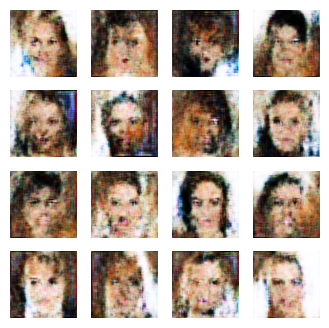

In [ ]:
import tensorflow as tf

def load_images(image_dir, batch_size=32, image_size=(128, 128)):
    dataset = tf.keras.utils.image_dataset_from_directory(
        image_dir,
        labels='inferred',  # Infer labels from subdirectory names
        label_mode='int',  # Ensures labels are provided as integers
        image_size=image_size,  # Resize images to match the model input size
        batch_size=batch_size,  # Use a specified batch size
        color_mode='rgb',  # Assuming the images are RGB
        shuffle=True,
        seed=6969,  # Random seed for reproducibility
    )
    return dataset

# Define dataroot here, making it accessible to this cell
dataroot = "/content/celeba/"

# Call the load_images function to create the dataset
dataset = load_images(dataroot)

# Call the train function with proper seed initialization
train(dataset, epochs=500)
